### Dataset
https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

- id: listing ID
- name: name of the listing
- host_id: host ID
- host_name: name of the host
- neighbourhood_group: location
- neighbourhood: area
- latitude: latitude coordinates
- longitude: longitude coordinates
- room_type: listing space type
- price: price in dollars
- minimum_nights: amount of nights minimum
- number_of_reviews: number of reviews
- last_review: latest review
- reviews_per_month: number of reviews per month
- calculated_host_listings_count: amount of listing per host
- availability_365: number of days when listing is available for booking

In [1]:
!python -V

Python 3.10.13


In [2]:
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Load data

In [4]:
df = pd.read_csv("datasets/airbnb-listings-may.csv")
df.shape

(394, 18)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              394 non-null    int64  
 1   name                            394 non-null    object 
 2   host_id                         394 non-null    int64  
 3   host_name                       394 non-null    object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   394 non-null    object 
 6   latitude                        394 non-null    float64
 7   longitude                       394 non-null    float64
 8   room_type                       394 non-null    object 
 9   price                           344 non-null    float64
 10  minimum_nights                  394 non-null    int64  
 11  number_of_reviews               394 non-null    int64  
 12  last_review                     349 

In [6]:
# Drop the data that are not of interest and/or causing privacy issues and redundant data
df.drop(['id','host_name','last_review', 'neighbourhood_group', 'license'], axis=1, inplace=True)
df.head()


,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,"Welcoming, easygoing, comfy bed, entire level",5294164,FOURTEENTH WARD,42.66719,-73.81580,Private room,50.0,1,250,1.93,1,255,48
1,Luxury 2 bedroom apartment,4621559,THIRD WARD,42.65789,-73.75370,Entire home/apt,NaN,28,9,0.08,1,36,0
2,Restored Precinct in Center Sq. w/Parking,19648678,SIXTH WARD,42.65222,-73.76724,Entire home/apt,118.0,2,300,2.53,4,361,15
3,Large studio apt by Capital Center & ESP@,29288920,SECOND WARD,42.64615,-73.75966,Entire home/apt,90.0,1,343,3.13,2,15,28
4,Center Sq. Loft in Converted Precinct w/ Parking,19648678,SIXTH WARD,42.65222,-73.76724,Entire home/apt,120.0,2,314,2.89,4,357,11


In [7]:
df.isnull().sum()

name                               0
host_id                            0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                             50
minimum_nights                     0
number_of_reviews                  0
reviews_per_month                 45
calculated_host_listings_count     0
availability_365                   0
number_of_reviews_ltm              0
dtype: int64

In [8]:
df.dropna(subset=['price'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
df.fillna({'reviews_per_month':0}, inplace=True)

In [10]:
# Making sure if any duplicatd values.
df.duplicated().sum()

0

In [11]:
# Drop duplicate rows based on all columns
# data = data.drop_duplicates().reset_index(drop=True)

In [12]:
#examine the dataset
(df[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365']]
 .describe())

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,344.000000,344.00000,344.000000,344.000000,344.000000,344.000000
mean,127.488372,4.12500,63.979651,2.077529,5.328488,220.066860
std,137.026183,8.03992,107.222268,2.068165,5.767578,106.466703
min,24.000000,1.00000,0.000000,0.000000,1.000000,3.000000
25%,76.500000,1.00000,6.000000,0.505000,1.000000,127.500000
50%,103.000000,1.00000,22.000000,1.525000,3.000000,242.000000
75%,135.000000,3.00000,74.250000,3.062500,8.000000,316.000000
max,1750.000000,89.00000,795.000000,11.050000,22.000000,365.000000


In [13]:
# Exclude property with listed price of 0
df = df.loc[df['price'] > 0]

In [14]:
# Insight about unique values
df.nunique()

name                              344
host_id                           166
neighbourhood                      15
latitude                          332
longitude                         332
room_type                           3
price                             139
minimum_nights                     16
number_of_reviews                 135
reviews_per_month                 236
calculated_host_listings_count     13
availability_365                  202
number_of_reviews_ltm              73
dtype: int64

In [15]:
df.isnull().sum()

name                              0
host_id                           0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
dtype: int64

### Exploratory Data Analysis


In [16]:
numerical = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
            'calculated_host_listings_count', 'availability_365']

categorical = ['room_type', 'neighbourhood']
target = ['price']

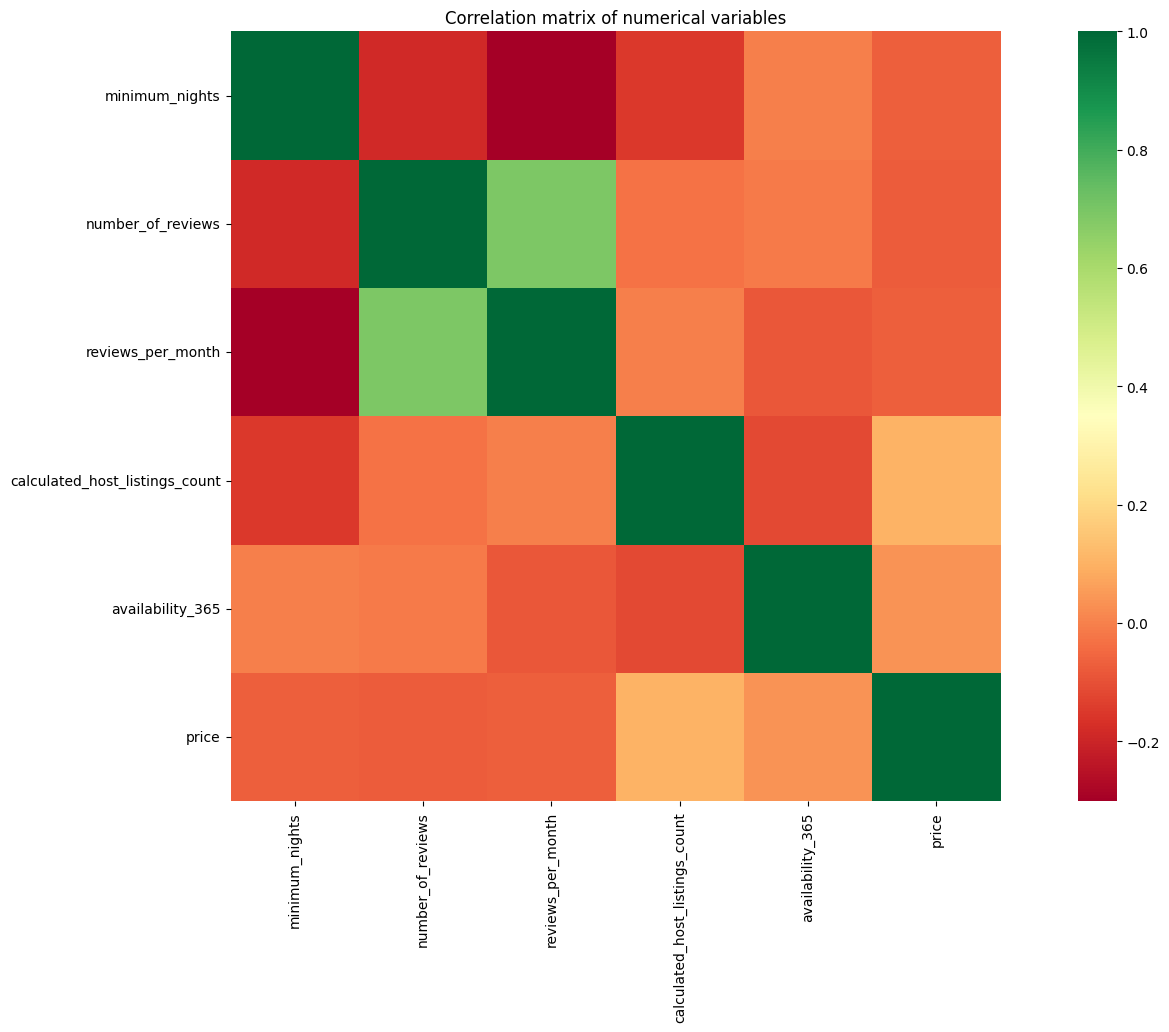

In [17]:
plt.figure(figsize=(20,10))
title = 'Correlation matrix of numerical variables'
sns.heatmap(df[numerical + target].corr(), square=True, cmap='RdYlGn')
plt.title(title)
plt.ioff()

#### Host

In [18]:
df.host_id.value_counts().iloc[:5]

host_id
232967878    22
47625981     15
382970529    11
152762198     9
37769478      9
Name: count, dtype: int64

In [19]:
df.host_id.value_counts().iloc[:5].plot(kind = 'barh')

<Axes: ylabel='host_id'>

#### Room type

In [20]:
df['room_type'].value_counts()

room_type
Entire home/apt    246
Private room        96
Shared room          2
Name: count, dtype: int64

In [23]:
fig = plt.figure(figsize=(5,5), dpi=80)
df['room_type'].value_counts().plot(kind='pie',  autopct='%1.0f%%', startangle=360, fontsize=13)
# fig.show()

<Axes: ylabel='count'>

#### Neighbourhood

In [24]:
df['neighbourhood'].value_counts().iloc[:5]

neighbourhood
SIXTH WARD         76
SECOND WARD        40
THIRTEENTH WARD    33
TENTH WARD         32
NINTH WARD         31
Name: count, dtype: int64

In [25]:
df['neighbourhood'].unique()

array(['FOURTEENTH WARD', 'SIXTH WARD', 'SECOND WARD', 'TENTH WARD',
       'FIFTEENTH WARD', 'ELEVENTH WARD', 'FIFTH WARD', 'NINTH WARD',
       'SEVENTH WARD', 'THIRTEENTH WARD', 'FOURTH WARD', 'EIGHTH WARD',
       'THIRD WARD', 'FIRST WARD', 'TWELFTH WARD'], dtype=object)

In [26]:
fig = plt.figure(figsize=(5,5), dpi=80)
df['neighbourhood'].value_counts().iloc[:5].plot(kind='pie',  autopct='%1.0f%%', startangle=360, fontsize=13)

<Axes: ylabel='count'>

#### Price

In [27]:
df.price.value_counts().iloc[:10]

price
100.0    16
125.0    11
120.0    11
50.0     10
55.0     10
45.0      9
75.0      9
110.0     8
105.0     7
136.0     7
Name: count, dtype: int64

In [28]:
df.price.value_counts().iloc[:10].plot(kind = 'bar')

<Axes: xlabel='price', ylabel='count'>

In [29]:
df.price.describe()

count     344.000000
mean      127.488372
std       137.026183
min        24.000000
25%        76.500000
50%       103.000000
75%       135.000000
max      1750.000000
Name: price, dtype: float64

In [30]:
df[df['price'] == 1750.000000]

,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
305,Charming 1920s house sleeps 6-7,30218591,FIFTEENTH WARD,42.67432,-73.815552,Entire home/apt,1750.0,2,0,0.0,1,143,0


#### Minimun nights

In [31]:
df['minimum_nights'].value_counts(ascending=True)

minimum_nights
15      1
89      1
6       1
25      1
10      2
28      2
13      4
5       5
18      7
14      7
7       8
4       9
30     13
3      32
2      78
1     173
Name: count, dtype: int64

In [32]:
for i in range(1,11):
  print("Number of nights: ",i)
  print("Amount of trasactions:",len(df[df['minimum_nights'] == i]))

Number of nights:  1
Amount of trasactions: 173
Number of nights:  2
Amount of trasactions: 78
Number of nights:  3
Amount of trasactions: 32
Number of nights:  4
Amount of trasactions: 9
Number of nights:  5
Amount of trasactions: 5
Number of nights:  6
Amount of trasactions: 1
Number of nights:  7
Amount of trasactions: 8
Number of nights:  8
Amount of trasactions: 0
Number of nights:  9
Amount of trasactions: 0
Number of nights:  10
Amount of trasactions: 2


In [33]:
df['minimum_nights'].value_counts().iloc[:4].plot(kind = 'barh')

<Axes: ylabel='minimum_nights'>

#### Number of reviews

In [34]:
df['number_of_reviews'].value_counts()

number_of_reviews
0      31
1      15
4      13
6      13
7      11
       ..
258     1
311     1
270     1
266     1
32      1
Name: count, Length: 135, dtype: int64

In [35]:
df[df['number_of_reviews'] == 311]

,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
54,Comfy and quiet,172223381,EIGHTH WARD,42.65085,-73.80239,Private room,57.0,1,311,5.49,2,121,103


#### Availability_365

In [36]:
df['availability_365'].value_counts()

availability_365
364    6
358    5
339    4
207    4
357    4
      ..
253    1
324    1
332    1
247    1
254    1
Name: count, Length: 202, dtype: int64

In [37]:
df[df['availability_365'] == 365].describe()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,3.000000e+00,3.000000,3.000000,3.000000,3.000000,3.00000,3.000000,3.000000,3.0,3.0
mean,4.056724e+06,42.672105,-73.802571,275.000000,1.666667,21.00000,0.326667,6.333333,365.0,0.0
std,3.516513e+05,0.003776,0.019221,27.622455,0.577350,31.32092,0.391067,4.618802,0.0,0.0
min,3.650672e+06,42.669190,-73.823950,253.000000,1.000000,0.00000,0.000000,1.000000,365.0,0.0
25%,3.955211e+06,42.669972,-73.810497,259.500000,1.500000,3.00000,0.110000,5.000000,365.0,0.0
50%,4.259750e+06,42.670754,-73.797044,266.000000,2.000000,6.00000,0.220000,9.000000,365.0,0.0
75%,4.259750e+06,42.673562,-73.791882,286.000000,2.000000,31.50000,0.490000,9.000000,365.0,0.0
max,4.259750e+06,42.676370,-73.786720,306.000000,2.000000,57.00000,0.760000,9.000000,365.0,0.0


#### Reviews per month

In [38]:
df[df['reviews_per_month'] > 1].reviews_per_month.value_counts().sum()                 

204

In [39]:
df[df['reviews_per_month'] > 1]['reviews_per_month'].value_counts().iloc[:5]            

reviews_per_month
2.00    3
3.10    3
1.93    2
1.67    2
1.72    2
Name: count, dtype: int64

In [40]:
df['reviews_per_month'].max()

11.05

In [41]:
df[df['reviews_per_month'] == 3.10]

,name,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
76,★ 2 BEDROOM / 1 BATH TRENDY Apt ★ Downtown Albany,47625981,SECOND WARD,42.647130,-73.756280,Entire home/apt,140.0,1,123,3.1,15,341,21
190,Cozy luxury brownstone w/ parking & yard,258664571,SECOND WARD,42.644394,-73.759757,Entire home/apt,134.0,2,45,3.1,2,320,41
318,New Center square studio,232967878,SIXTH WARD,42.652689,-73.765674,Entire home/apt,93.0,2,6,3.1,22,77,6


#### Calculated host listings

In [42]:
df.calculated_host_listings_count.value_counts().iloc[:5]

calculated_host_listings_count
1    94
2    63
3    43
4    31
9    26
Name: count, dtype: int64

In [43]:
df.calculated_host_listings_count.value_counts().iloc[:5].plot(kind = 'bar')


<Axes: xlabel='calculated_host_listings_count', ylabel='minimum_nights'>

In [44]:
df.calculated_host_listings_count.describe()

count    344.000000
mean       5.328488
std        5.767578
min        1.000000
25%        1.000000
50%        3.000000
75%        8.000000
max       22.000000
Name: calculated_host_listings_count, dtype: float64

#### Coorelation

In [45]:
corr = df[numerical].corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)

<Axes: >

### Data Preparation

In [46]:
df = pd.read_csv("datasets/airbnb-listings-may.csv")

In [47]:
df.drop(['host_id','name','latitude','longitude','id','host_name','last_review', 'neighbourhood_group', 'license'], axis=1, inplace=True)
df.head()

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,FOURTEENTH WARD,Private room,50.0,1,250,1.93,1,255,48
1,THIRD WARD,Entire home/apt,NaN,28,9,0.08,1,36,0
2,SIXTH WARD,Entire home/apt,118.0,2,300,2.53,4,361,15
3,SECOND WARD,Entire home/apt,90.0,1,343,3.13,2,15,28
4,SIXTH WARD,Entire home/apt,120.0,2,314,2.89,4,357,11


In [48]:
# Drop rows where 'price' is NaN
df.dropna(subset=['price'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [49]:
df['reviews_per_month'].describe()

count    313.000000
mean       2.283291
std        2.056933
min        0.040000
25%        0.690000
50%        1.720000
75%        3.160000
max       11.050000
Name: reviews_per_month, dtype: float64

In [50]:
df.fillna({'reviews_per_month':0}, inplace=True)

In [51]:
df.isna().sum()

neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
dtype: int64

In [52]:
import plotly.express as px

fig = px.box(df, y="price")
fig.update_layout(
    autosize=False,
    width=500,
    height=400
)
fig.show()

In [53]:
dfp = df["price"][df["price"] < 230]
dfp[dfp > 0].hist()

<Axes: >

In [54]:
df=df[df["price"]<201]
df=df[df["price"]>0]
df['room_type'].value_counts()

room_type
Entire home/apt    220
Private room        93
Shared room          2
Name: count, dtype: int64

In [55]:
fig = px.box(df, y="price")
fig

In [56]:
df.head()

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,FOURTEENTH WARD,Private room,50.0,1,250,1.93,1,255,48
1,SIXTH WARD,Entire home/apt,118.0,2,300,2.53,4,361,15
2,SECOND WARD,Entire home/apt,90.0,1,343,3.13,2,15,28
3,SIXTH WARD,Entire home/apt,120.0,2,314,2.89,4,357,11
4,TENTH WARD,Private room,199.0,3,18,0.17,2,179,0


In [57]:
# Feature selection
numerical = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm']
categorical = ['room_type', 'neighbourhood']
target = ['price']

In [58]:
data = df[numerical + categorical + target]
data[categorical] = data[categorical].astype(str)
data.head()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,room_type,neighbourhood,price
0,1,250,1.93,1,255,48,Private room,FOURTEENTH WARD,50.0
1,2,300,2.53,4,361,15,Entire home/apt,SIXTH WARD,118.0
2,1,343,3.13,2,15,28,Entire home/apt,SECOND WARD,90.0
3,2,314,2.89,4,357,11,Entire home/apt,SIXTH WARD,120.0
4,3,18,0.17,2,179,0,Private room,TENTH WARD,199.0


In [59]:
# data = pd.get_dummies(data, columns=["room_type"], drop_first=True)
# data = pd.get_dummies(data, columns=['neighbourhood'], drop_first=True)
# data.head()

In [60]:
# Compute correlation matrix
correlation_matrix = data[numerical + target].corr()

# Extract correlation with price
correlation_with_price = correlation_matrix['price'].sort_values(ascending=False)
correlation_with_price

price                             1.000000
calculated_host_listings_count    0.205387
reviews_per_month                 0.141089
number_of_reviews_ltm             0.116974
availability_365                 -0.001938
number_of_reviews                -0.033770
minimum_nights                   -0.220593
Name: price, dtype: float64

In [61]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'price'
y_train = df[target].values
y_train = np.log10(y_train)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

0.14068543254752267

In [62]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [63]:
print("intercept is: ",lr.intercept_)

print("coefficients are: ",lr.coef_)

intercept is:  1.8912138916623207
coefficients are:  [ 2.84480230e-05  3.88734298e-03 -4.39545626e-03  3.88504614e-02
 -6.03270339e-02  8.31606789e-03 -2.59797067e-02  9.92619747e-02
 -8.25124760e-02  3.54283453e-02 -5.40577019e-02 -2.08766494e-02
 -2.34596350e-02  1.98473774e-03  3.80027589e-02 -5.15788822e-02
 -2.77164830e-02  1.24664222e-01 -3.06891643e-04  7.93415194e-04
  1.87608872e-03  1.48812303e-01 -5.07161642e-02 -9.80961388e-02]
